## Semi-supervised Learning

author: Jacob Schreiber <br>
contact:
jmschreiber91@gmail.com

Most classical machine learning algorithms either
assume that an entire dataset is either labeled (supervised learning) or that
there are no labels (unsupervised learning). However, frequently it is the case
that some labeled data is present but there is a great deal of unlabeled data as
well. A great example of this is that of computer vision where the internet is
filled of pictures (mostly of cats) that could be useful, but you don't have the
time or money to label them all in accordance with your specific task. Typically
what ends up happening is that either the unlabeled data is discarded in favor
of training a model solely on the labeled data, or that an unsupervised model is
initialized with the labeled data and then set free on the unlabeled data.
Neither method uses both sets of data in the optimization process.

Semi-
supervised learning is a method to incorporate both labeled and unlabeled data
into the training task, typically yield better performing estimators than using
the labeled data alone. There are many methods one could use for semisupervised
learning, and <a href="http://scikit-
learn.org/stable/modules/label_propagation.html">scikit-learn has a good write-
up on some of these techniques</a>.

pomegranate natively implements semi-
supervised learning through the a merger of maximum-likelihood and expectation-
maximization. As an overview, the models are initialized by first fitting to the
labeled data directly using maximum-likelihood estimates. The models are then
refined by running expectation-maximization (EM) on the unlabeled datasets and
adding the sufficient statistics to those acquired from maximum-likelihood
estimates on the labeled data. Under the hood both a supervised model and an
unsupervised mixture model are created using the same underlying distribution
objects. The summarize method is first called using the supervised method on the
labeled data, and then the summarize method is called again using the
unsupervised method on the unlabeled data. This causes the sufficient statistics
to be updated appropriately given the results of first maximum-likelihood and
then EM. This process continues until convergence in the EM step.

Let's take a
look!

In [1]:
%matplotlib inline
import time
import pandas
import random
import numpy
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import itertools

from pomegranate import *

random.seed(0)
numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%load_ext watermark
%watermark -m -n -p numpy,scipy,pomegranate

Fri Apr 26 2019 

numpy 1.15.4
scipy 1.2.1
pomegranate 0.10.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-17763-Microsoft
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [2]:
%pylab inline
from pomegranate import *
from sklearn.semi_supervised import LabelPropagation
from sklearn.datasets import make_blobs
import seaborn, time
seaborn.set_style('whitegrid')
numpy.random.seed(1)

Let's first generate some data in the form of blobs that are close together.
Generally one tends to have far more unlabeled data than labeled data, so let's
say that a person only has 50 samples of labeled training data and 4950
unlabeled samples. In pomegranate you a sample can be specified as lacking a
label by providing the integer -1 as the label, just like in scikit-learn. Let's
also say there there is a bit of bias in the labeled samples to inject some
noise into the problem, as otherwise Gaussian blobs are trivially modeled with
even a few samples.

In [3]:
X, y = make_blobs(10000, 2, 3, cluster_std=2)
x_min, x_max = X[:,0].min()-2, X[:,0].max()+2
y_min, y_max = X[:,1].min()-2, X[:,1].max()+2

X_train = X[:5000]
y_train = y[:5000]

# Set the majority of samples to unlabeled.
y_train[numpy.random.choice(5000, size=4950, replace=False)] = -1

# Inject noise into the problem
X_train[y_train != -1] += 2.5

X_test = X[5000:]
y_test = y[5000:]

Now let's take a look at the data when we plot it.

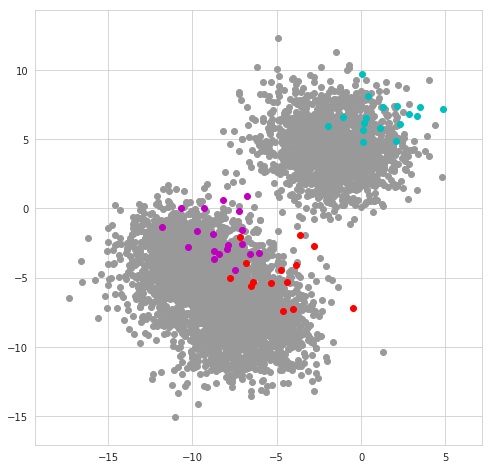

In [4]:
plt.figure(figsize=(8, 8))
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], color='0.6')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='c')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='m')
plt.scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1], color='r')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

The clusters of unlabeled data seem clear to us, and it doesn't seem like the
labeled data is perfectly faithful to these clusters. This can typically happen
in a semisupervised setting as well, as the data that is labeled is sometimes
biased either because the labeled data was chosen as it was easy to label, or
the data was chosen to be labeled in a biased maner.

Now let's try fitting a
simple naive Bayes classifier to this data and compare the results when using
only the labeled data to when using both the labeled and unlabeled data
together.

In [5]:
model_a = NaiveBayes.from_samples(NormalDistribution, X_train[y_train != -1], y_train[y_train != -1])
print( "Supervised Learning Accuracy: {}".format((model_a.predict(X_test) == y_test).mean()))

model_b = NaiveBayes.from_samples(NormalDistribution, X_train, y_train)
print( "Semisupervised Learning Accuracy: {}".format((model_b.predict(X_test) == y_test).mean()))

Supervised Learning Accuracy: 0.8706
Semisupervised Learning Accuracy: 0.9274


It seems like we get a big bump in test set accuracy when we use semi-supervised
learning. Let's visualize the data to get a better sense of what is happening
here.

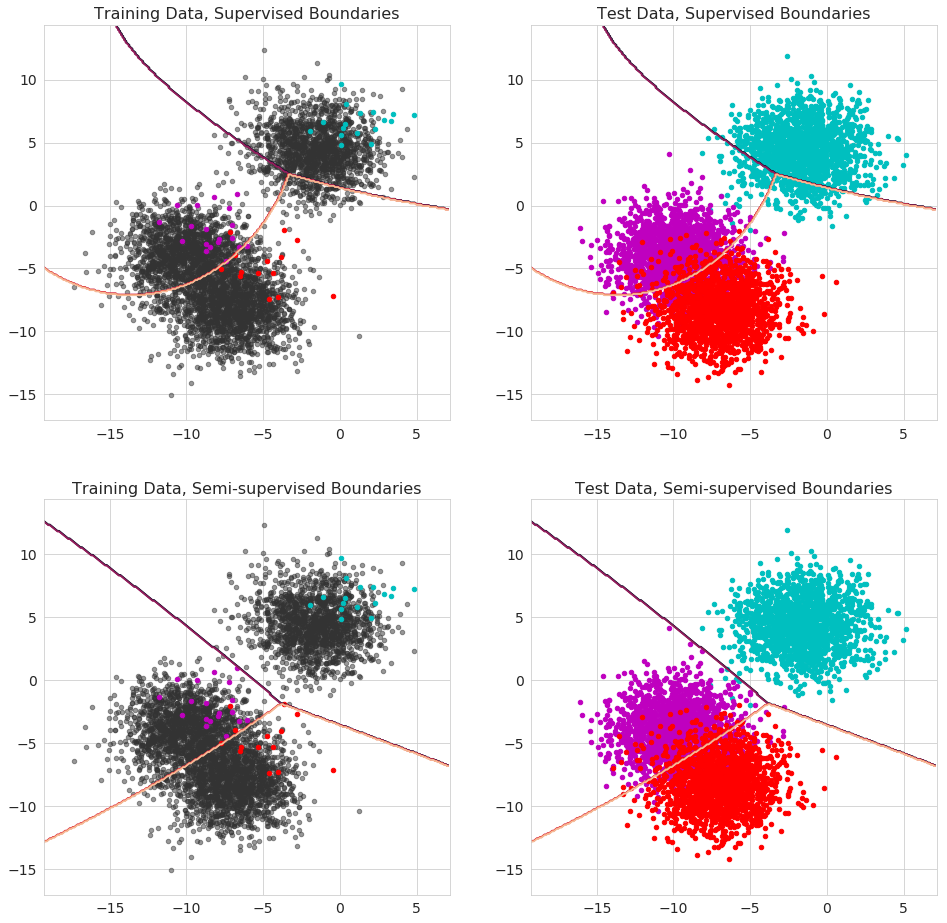

In [6]:
def plot_contour(X, y, Z):
    plt.scatter(X[y == -1, 0], X[y == -1, 1], color='0.2', alpha=0.5, s=20)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='c', s=20)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='m', s=20)
    plt.scatter(X[y == 2, 0], X[y == 2, 1], color='r', s=20)
    plt.contour(xx, yy, Z)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, 0.1), numpy.arange(y_min, y_max, 0.1))
Z1 = model_a.predict(numpy.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z2 = model_b.predict(numpy.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.title("Training Data, Supervised Boundaries", fontsize=16)
plot_contour(X_train, y_train, Z1)

plt.subplot(223)
plt.title("Training Data, Semi-supervised Boundaries", fontsize=16)
plot_contour(X_train, y_train, Z2)

plt.subplot(222)
plt.title("Test Data, Supervised Boundaries", fontsize=16)
plot_contour(X_test, y_test, Z1)

plt.subplot(224)
plt.title("Test Data, Semi-supervised Boundaries", fontsize=16)
plot_contour(X_test, y_test, Z2)
plt.show()

The contours plot the decision boundaries between the different classes with the
left figures corresponding to the partially labeled training set and the right
figures corresponding to the test set. We can see that the boundaries learning
using only the labeled data look a bit weird when considering the unlabeled
data, particularly in that it doesn't cleanly separate the cyan cluster from the
other two. In addition, it seems like the boundary between the magenta and red
clusters is a bit curved in an unrealistic way. We would not expect points that
fell around (-18, -7) to actually come from the red class. Training the model in
a semi-supervised manner cleaned up both of these concerns by learning better
boundaries that are also flatter and more generalizable.

Let's next compare the
training times to see how much slower it is to do semi-supervised learning than
it is to do simple supervised learning.

In [7]:
print( "Supervised Learning: ")
%timeit NaiveBayes.from_samples(NormalDistribution, X_train[y_train != -1], y_train[y_train != -1])
print( "Semi-supervised Learning: ")
%timeit NaiveBayes.from_samples(NormalDistribution, X_train, y_train)
print( "Label Propagation (sklearn): ")
%timeit LabelPropagation().fit(X_train, y_train)

It is quite a bit slower to do semi-supervised learning than simple supervised
learning in this example. This is expected as the simple supervised update for
naive Bayes is a trivial MLE across each dimension whereas the semi-supervised
case requires EM to converge to complete. However, it is still faster to do
semi-supervised learning this setting to learn a naive Bayes classifier than it
is to fit the label propagation estimator from sklearn. 

However, though it is
widely used, the naive Bayes classifier is still a fairly simple model. One can
construct a more complicated model that does not assume feature independence
called a Bayes classifier that can also be trained using semi-supervised
learning in pretty much the same manner. You can read more about the Bayes
classifier in its tutorial in the tutorial folder. Let's move on to more
complicated data and try to fit a mixture model Bayes classifier, comparing the
performance between using only labeled data and using all data.

First let's
generate some more complicated, noisier data.

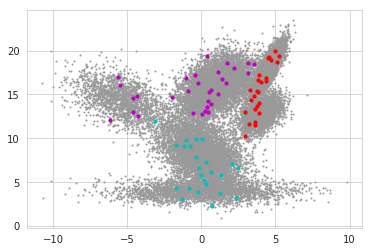

In [8]:
X = numpy.empty(shape=(0, 2))
X = numpy.concatenate((X, numpy.random.normal(4, 1, size=(3000, 2)).dot([[-2, 0.5], [2, 0.5]])))
X = numpy.concatenate((X, numpy.random.normal(3, 1, size=(6500, 2)).dot([[-1, 2], [1, 0.8]])))
X = numpy.concatenate((X, numpy.random.normal(7, 1, size=(8000, 2)).dot([[-0.75, 0.8], [0.9, 1.5]])))
X = numpy.concatenate((X, numpy.random.normal(6, 1, size=(2200, 2)).dot([[-1.5, 1.2], [0.6, 1.2]])))
X = numpy.concatenate((X, numpy.random.normal(8, 1, size=(3500, 2)).dot([[-0.2, 0.8], [0.7, 0.8]])))
X = numpy.concatenate((X, numpy.random.normal(9, 1, size=(6500, 2)).dot([[-0.0, 0.8], [0.5, 1.2]])))
x_min, x_max = X[:,0].min()-2, X[:,0].max()+2
y_min, y_max = X[:,1].min()-2, X[:,1].max()+2

y = numpy.concatenate((numpy.zeros(9500), numpy.ones(10200), numpy.ones(10000)*2))
idxs = numpy.arange(29700)
numpy.random.shuffle(idxs)

X = X[idxs]
y = y[idxs]

X_train, X_test = X[:25000], X[25000:]
y_train, y_test = y[:25000], y[25000:]
y_train[numpy.random.choice(25000, size=24920, replace=False)] = -1

plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], color='0.6', s=1)
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='c', s=10)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='m', s=10)
plt.scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1], color='r', s=10)
plt.show()

Now let's take a look at the accuracies that we get when training a model using
just the labeled examples versus all of the examples in a semi-supervised
manner.

In [9]:
d1 = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X_train[y_train == 0], max_iterations=1)
d2 = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X_train[y_train == 1], max_iterations=1)
d3 = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X_train[y_train == 2], max_iterations=1)
model_a = BayesClassifier([d1, d2, d3]).fit(X_train[y_train != -1], y_train[y_train != -1])
print( "Supervised Learning Accuracy: {}".format((model_a.predict(X_test) == y_test).mean()))

d1 = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X_train[y_train == 0], max_iterations=1)
d2 = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X_train[y_train == 1], max_iterations=1)
d3 = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X_train[y_train == 2], max_iterations=1)
model_b = BayesClassifier([d1, d2, d3])
model_b.fit(X_train, y_train)
print( "Semisupervised Learning Accuracy: {}".format((model_b.predict(X_test) == y_test).mean()))

Supervised Learning Accuracy: 0.9361702127659575
Semisupervised Learning Accuracy: 0.9846808510638297


As expected, the semi-supervised method performs better. Let's visualize the
landscape in the same manner as before in order to see why this is the case.

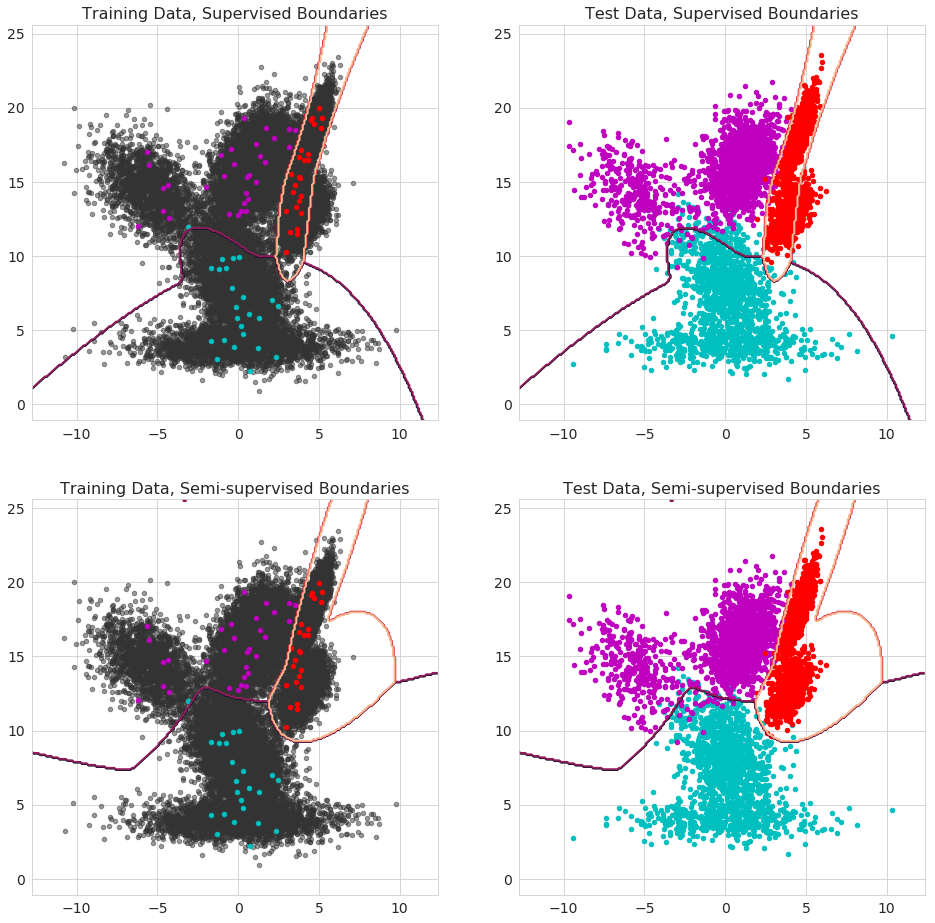

In [10]:
xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, 0.1), numpy.arange(y_min, y_max, 0.1))
Z1 = model_a.predict(numpy.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z2 = model_b.predict(numpy.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.title("Training Data, Supervised Boundaries", fontsize=16)
plot_contour(X_train, y_train, Z1)

plt.subplot(223)
plt.title("Training Data, Semi-supervised Boundaries", fontsize=16)
plot_contour(X_train, y_train, Z2)

plt.subplot(222)
plt.title("Test Data, Supervised Boundaries", fontsize=16)
plot_contour(X_test, y_test, Z1)

plt.subplot(224)
plt.title("Test Data, Semi-supervised Boundaries", fontsize=16)
plot_contour(X_test, y_test, Z2)
plt.show()

Immediately, one would notice that the decision boundaries when using semi-
supervised learning are smoother than those when using only a few samples. This
can be explained mostly because having more data can generally lead to smoother
decision boundaries as the model does not overfit to spurious examples in the
dataset. It appears that the majority of the correctly classified samples come
from having a more accurate decision boundary for the magenta samples in the
left cluster. When using only the labeled samples many of the magenta samples in
this region get classified incorrectly as cyan samples. In contrast, when using
all of the data these points are all classified correctly.

Lastly, let's take a
look at a time comparison in this more complicated example.

In [11]:
d1 = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X_train[y_train == 0], max_iterations=1)
d2 = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X_train[y_train == 1], max_iterations=1)
d3 = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X_train[y_train == 2], max_iterations=1)
model = BayesClassifier([d1, d2, d3])

print( "Supervised Learning: ")
%timeit model.fit(X_train[y_train != -1], y_train[y_train != -1])

d1 = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X_train[y_train == 0], max_iterations=1)
d2 = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X_train[y_train == 1], max_iterations=1)
d3 = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X_train[y_train == 2], max_iterations=1)
model = BayesClassifier([d1, d2, d3])

print( "Semi-supervised Learning: ")
%timeit model.fit(X_train, y_train)

print
print( "Label Propagation (sklearn): ")
%timeit LabelPropagation().fit(X_train, y_train)

It looks like the difference, while still large, is not as large as in the
previous example, being only a ~40x difference instead of a ~1000x difference.
This is likely because even without the unlabeled data the supervised model is
performing EM to train each of the mixtures that are the components of the Bayes
classifier. Again, it is faster to do semi-supervised learning in this manner
for generative models than it is to perform LabelPropagation.

## Summary

In
the real world (ack) there are frequently situations where only a
small fraction
of the available data has useful labels. Semi-supervised learning
provides a
framework for leveraging both the labeled and unlabeled aspects of a
dataset to
learn a sophisticated estimator. In this case, semi-supervised
learning plays
well with probabilistic models as normal maximum likelihood
estimates can be
done on the labeled data and expectation-maximization can be
run on the
unlabeled data using the same distributions.

This notebook has
covered how to
implement semi-supervised learning in pomegranate using both
naive Bayes and a
Bayes classifier. All one has to do is set the labels of
unlabeled samples to -1
and pomegranate will take care of the rest. This can be
particularly useful when
encountering complex, noisy, data in the real world
that aren't neat Gaussian
blobs.